In [1]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import tensorflow_probability as tfp

module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v11/"
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11'

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
BATCH_SIZE = 256
N_DATA = 4000
T = 20
VOCAB = ['start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 128

## Load Data

In [3]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
# neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path, use_init_token=False):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
        
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    
    return et_seqs, ts_seqs

raw_pos_event_type_seqs, raw_pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path, use_init_token=False)

In [4]:
# cast indicator data into one-hot
pos_event_type_seqs = tf.cast(raw_pos_event_type_seqs, tf.int32)
pos_event_type_seqs = tf.one_hot(pos_event_type_seqs, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
pos_event_type_seqs = tf.squeeze(pos_event_type_seqs, axis=3)

In [5]:
def zcore_norm(data):
    N = data.shape[0]
    
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)
    _mean = tf.repeat(_mean, N, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return (data - _mean) / _std, _mean[0,:,:], _std[0,:,:]

def zcore_norm_2(data, _mean, _std):
    N = data.shape[0]
    
    _mean = tf.expand_dims(_mean, axis=0)
    _mean = tf.repeat(_mean, N, axis=0)

    _std = tf.expand_dims(_std, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return (data - _mean) / _std, _mean[0,:,:], _std[0,:,:]

def get_mean_std(data):
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)

    return _mean, _std

def apply_mean_std(data, _mean, _std):
    N = data.shape[0]
    
    _mean = tf.reshape(_mean, (1, T, 1))
    _mean = tf.repeat(_mean, N, axis=0)
    
    _std = tf.reshape(_std, (1, T, 1))
    _std = tf.repeat(_std, N, axis=0)
    
    return data * _std + _mean

pos_timestamp_seqs, GLOBAL_MEAN, GLOBAL_STD = zcore_norm(raw_pos_timestamp_seqs)

## Global Functions

In [6]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [7]:
def generate_initial_noise(max_token=EVENT_VOCAB_DIM, time_mean=0, time_std=1, zero_time_start=True):
    init_token_noise_index = tf.random.uniform(shape=[BATCH_SIZE, 1, 1], maxval=max_token, dtype=tf.int32)
    init_token_noise = tf.squeeze(tf.one_hot(init_token_noise_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
        
    if zero_time_start:
        init_time_noise = tf.zeros([BATCH_SIZE, 1, 1], dtype=tf.float64)           
    else:
        init_time_noise = tf.random.truncated_normal(shape=[BATCH_SIZE, 1, 1], mean=time_mean, stddev=time_std, dtype=tf.float64)
        
    return init_token_noise, init_time_noise

In [8]:
from scipy.linalg import sqrtm

def calculate_FID_batch(batch1, batch2, weight=1, N=4000, T=20):
    batch1, batch2 = np.array(batch1).reshape((N, T)), np.array(batch2).reshape((N, T))
    mu1, sigma1 = batch1.mean(axis=0), np.cov(batch1, rowvar=False)
    mu2, sigma2 = batch2.mean(axis=0), np.cov(batch2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid2 = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid2

calculate_FID_score = lambda batch: calculate_FID_batch(raw_pos_timestamp_seqs, batch)
# calculate_FID_score(raw_pos_timestamp_seqs)

In [9]:
class MAD:
    """ Sum square of one-hot distance between tokens
    Params:
    -- batch1         : The first batch of sequences to be compared with the second one
                        or it can be the comparison base
    -- batch2
    Returns:
    --   : dict, sum square of distances and base medians
    """

    def __init__(self):
        self.base_ssad = []
        self.base_med = []
        self.base_med_oh = []
        self.one_hot_map = {0: [1, 0, 0, 0],
                            1: [0, 1, 0, 0],
                            2: [0, 0, 1, 0],
                            3: [0, 0, 0, 1]}

    def nan_if(self, arr, value):
        return np.where(arr == value, np.nan, arr)

    def fit(self, batch1):
        assert len(batch1) > 1, 'batch1 should have more than one sequence'
        X_tok = []
        for i in batch1:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        self.base_med = medians
        self.base_med_oh = medians_oh
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(medians_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        self.base_ssad = np.mean(tok_dist)

    def compare(self, batch2):
        assert len(batch2) > 1, 'batch2 should have more than one sequence'
        X_tok = []
        for i in batch2:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(self.base_med_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        compare_ssd = np.mean(tok_dist)
        return {'mad': compare_ssd,
                'base_medians': np.array(self.base_med),
                'base_medians_oh': np.array(self.base_med_oh),
                'comp_medians': np.array(medians),
                'comp_medians_oh': np.array(medians_oh)}
    
mad_obj = MAD()
mad_obj.fit(raw_pos_event_type_seqs)
calculate_MAD_score = lambda batch: mad_obj.compare(batch)['mad']
# calculate_MAD_score(raw_pos_event_type_seqs)

def calculate_self_MAD_score(batch):
    self_mad_obj = MAD()
    self_mad_obj.fit(batch)
    return self_mad_obj.compare(batch)['mad']

In [10]:
EVENT_TYPES = ['A', 'B', 'C', 'D']
EVENT_ENCODE = {'A':0, 'B':1, 'C':2, 'D':3}

MIN_SAME_DELAY = 20
MAX_PAIR_DELAY = 200


def check_min_delay_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]
    prev_et, _ = None, 0.0
    for et, dt in seq:
        if et == prev_et and dt < MIN_SAME_DELAY:
            return False
        prev_et = et
    return True

def check_paring_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]    
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if seq[i][0] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif seq[i][0] == EVENT_ENCODE['C'] and queue: # encounter a C event
            queue.pop(0)
    return len(queue) == 0

def check_max_delay_rule(seq, use_init_token=False):    
    if use_init_token:
        seq = seq[1:]    
        
    def recover_timedelta_to_timestamp(time_seq):
        csum = []
        curr = 0
        for dt in time_seq:
            if dt != 0:
                curr += dt
                csum.append(curr)
            else:
                csum.append(0)
        return csum
    
    ets = [e[0] for e in seq]
    tss = recover_timedelta_to_timestamp([e[1] for e in seq])
        
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if ets[i] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif ets[i] == EVENT_ENCODE['C'] and queue: # encounter a C event
            if tss[queue[0]] - tss[i] <= MAX_PAIR_DELAY:
                queue.pop(0)
            else:
                return False
    # for rule 6, it's fine if there are unpaired D in queue
    # b/c this rules is to ensure for each paired (C, D), the delay is bounded
    return True


def calculate_rule_score(batch):
    N_batch = batch.shape[0]
    cnt = 0
    for i in range(N_batch):
        seq = batch[i, :, :]
        if check_min_delay_rule(seq) and check_paring_rule(seq) and check_max_delay_rule(seq):
            cnt += 1    
    return cnt / N_batch

# MLE-Pretraining

In [19]:
df_pretrain_gs = pd.read_csv('/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-09-37-30/pretrain_stats.csv', index_col=0)
df_pretrain_rl = pd.read_csv('/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/pretrain/2021-04-02-07-42-15/pretrain_stats.csv', index_col=0)

## RL MLE pretrain : overfitting on continuous dimension

In [22]:
df_pretrain_rl

,mad,fid,oracle,gen_loss,token_loss,time_loss
0,0.826562,19892.478264,0.00150,5.850038,1.580409,4.269629
1,0.825512,18094.512528,0.00150,5.328003,1.572294,3.755709
2,0.821875,16461.974366,0.00125,4.999330,1.577041,3.422289
3,0.825237,14667.362713,0.00225,4.590451,1.566818,3.023633
4,0.823725,13245.832006,0.00375,4.244756,1.555551,2.689205
...,...,...,...,...,...,...
87,0.661362,109.777720,0.09500,2.730798,1.331264,1.399534
88,0.663212,110.187098,0.08725,2.748187,1.330673,1.417514
89,0.660837,109.053740,0.09550,2.758684,1.342011,1.416673
90,0.661050,104.421874,0.09000,2.750665,1.338694,1.411972


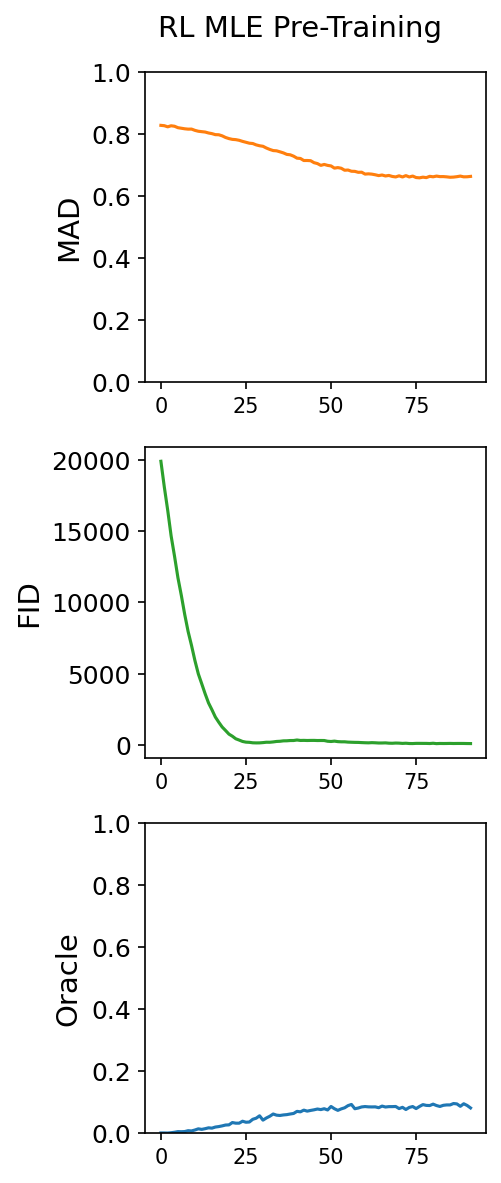

In [119]:
fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(3, 8),dpi=150)

fig.suptitle('RL MLE Pre-Training', fontsize=14)
fig.tight_layout()
x = df_pretrain_rl.index

ax1.plot(x, df_pretrain_rl['mad'], 'tab:orange')
ax1.set_ylabel('MAD', fontsize=14)
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=12)
ax1.set_ylim([0,1])

ax2.plot(x, df_pretrain_rl['fid'], 'tab:green')
ax2.set_ylabel('FID', fontsize=14)
ax2.tick_params(axis="x", labelsize=10)
ax2.tick_params(axis="y", labelsize=12)

ax3.plot(x, df_pretrain_rl['oracle'], 'tab:blue')
ax3.set_ylabel('Oracle',fontsize=14)
ax3.set_ylim([0,1])
ax3.tick_params(axis="x", labelsize=10)
ax3.tick_params(axis="y", labelsize=12)


# for ax in fig.get_axes():
#     ax.label_outer()

In [61]:
delta_fid = abs((df_pretrain_rl['fid'][0]-df_pretrain_rl['fid'][91]) / df_pretrain_rl['fid'][0])
delta_mad = abs((df_pretrain_rl['mad'][0]-df_pretrain_rl['mad'][91]) / df_pretrain_rl['mad'][0])
delta_ora = abs((df_pretrain_rl['oracle'][0]-df_pretrain_rl['oracle'][91]) / df_pretrain_rl['oracle'][0])

delta_fid, delta_mad, delta_ora

(0.9948826275661776, 0.198805293005671, 53.666666666666664)

## GS MLE pretrain : Minor improvement on continuous dimension

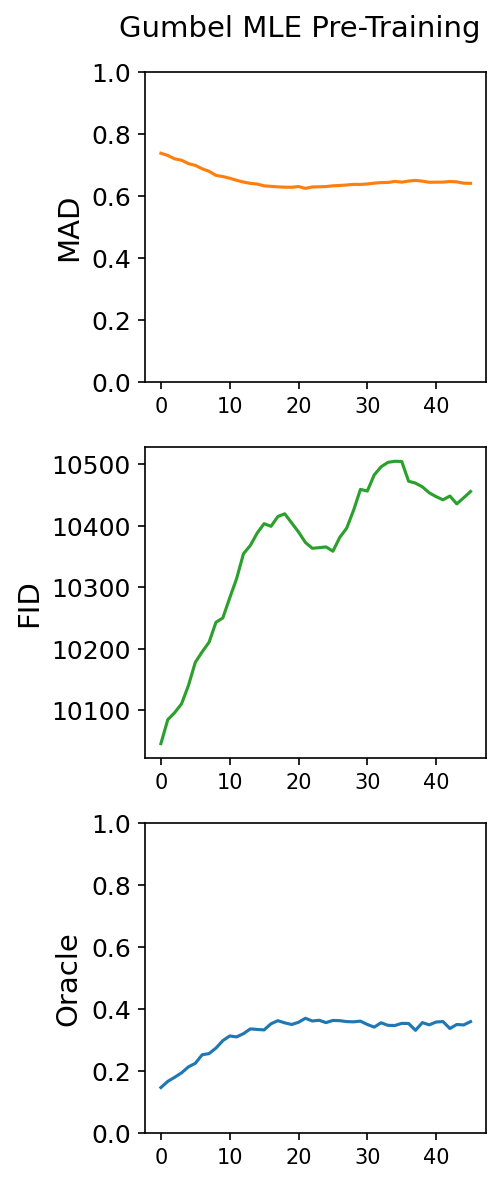

In [120]:
fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(3, 8),dpi=150)

fig.suptitle('Gumbel MLE Pre-Training', fontsize=14)
fig.tight_layout()
x = df_pretrain_gs.index

ax1.plot(x, df_pretrain_gs['mad'], 'tab:orange')
ax1.set_ylabel('MAD', fontsize=14)
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=12)
ax1.set_ylim([0,1])

ax2.plot(x, df_pretrain_gs['fid'], 'tab:green')
ax2.set_ylabel('FID', fontsize=14)
ax2.tick_params(axis="x", labelsize=10)
ax2.tick_params(axis="y", labelsize=12)

ax3.plot(x, df_pretrain_gs['oracle'], 'tab:blue')
ax3.set_ylabel('Oracle',fontsize=14)
ax3.set_ylim([0,1])
ax3.tick_params(axis="x", labelsize=10)
ax3.tick_params(axis="y", labelsize=12)


# for ax in fig.get_axes():
#     ax.label_outer()

# Training metrics curves

In [ ]:
GS: train/2021-04-02-11-07-12
RL: train/2021-04-02-09-25-47

In [71]:
df_train_gs = pd.read_csv('/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/train_metrics.csv', index_col=0)
df_train_rl = pd.read_csv('/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-mcc-v11/train/2021-04-02-09-25-47/train_metrics.csv', index_col=0)

## RL train

In [73]:
df_train_rl

,mad,fid,oracle
0,0.645687,188.587346,0.09100
5,0.646075,425.224295,0.10775
10,0.642763,937.777147,0.12875
15,0.642713,1724.744242,0.16125
20,0.639150,2709.305914,0.19000
...,...,...,...
435,0.071313,9149.998071,0.04100
440,0.072500,9144.897883,0.03400
445,0.070288,9241.329784,0.02800
450,0.069562,9377.992634,0.03225


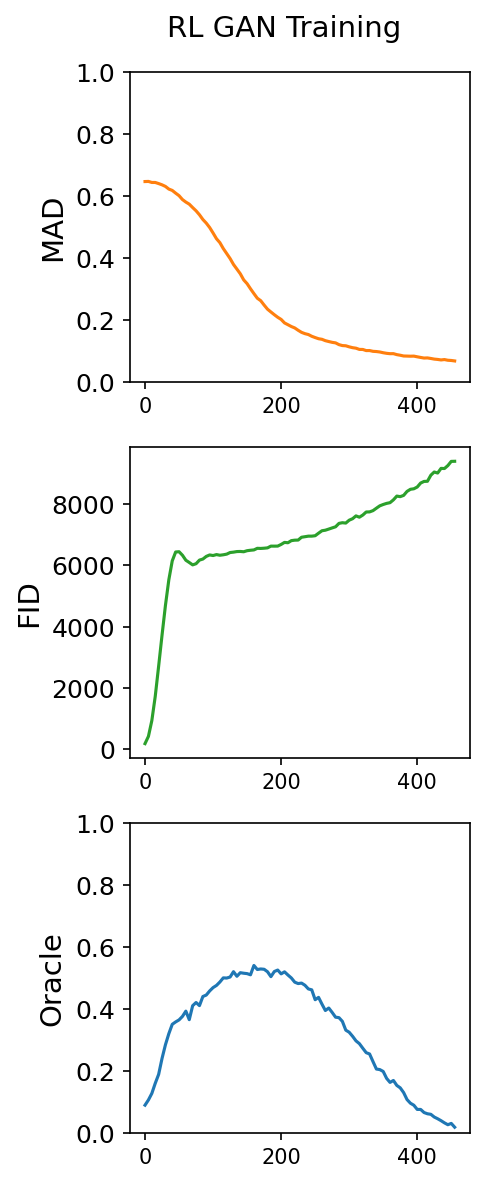

In [134]:
fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(3, 8) ,dpi=150)

fig.suptitle('RL GAN Training', fontsize=14)
fig.tight_layout()
x = df_train_rl.index

ax1.plot(x, df_train_rl['mad'], 'tab:orange')
ax1.set_ylabel('MAD', fontsize=14)
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=12)
ax1.set_ylim([0,1])

ax2.plot(x, df_train_rl['fid'], 'tab:green')
ax2.set_ylabel('FID', fontsize=14)
ax2.tick_params(axis="x", labelsize=10)
ax2.tick_params(axis="y", labelsize=12)

ax3.plot(x, df_train_rl['oracle'], 'tab:blue')
ax3.set_ylabel('Oracle',fontsize=14)
ax3.set_ylim([0,1])
ax3.tick_params(axis="x", labelsize=10)
ax3.tick_params(axis="y", labelsize=12)


# for ax in fig.get_axes():
#     ax.label_outer()

## GS train

In [76]:
df_train_gs

,mad,fid,oracle
0,0.642863,1.046944e+04,0.35400
5,0.633275,1.015545e+04,0.35400
10,0.622875,1.057871e+04,0.35050
15,0.608062,1.172512e+04,0.35350
20,0.601975,1.364831e+04,0.33125
...,...,...,...
470,0.839137,2.216894e+06,0.05000
475,0.834925,2.300478e+06,0.05450
480,0.833300,2.402094e+06,0.06375
485,0.835475,2.533333e+06,0.06075


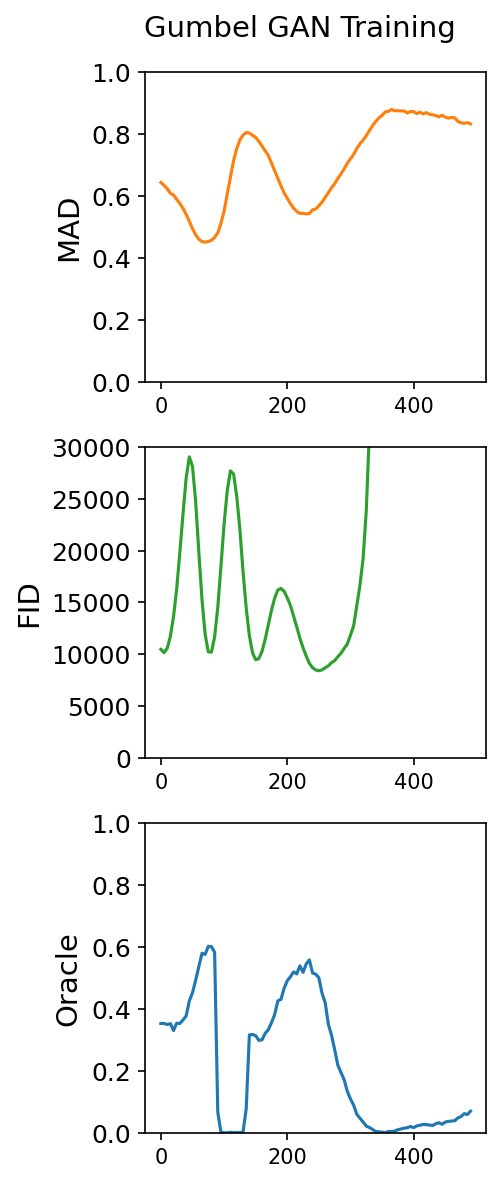

In [133]:
fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(3, 8),dpi=150)

fig.suptitle('Gumbel GAN Training', fontsize=14)
fig.tight_layout()
x = df_train_gs.index

ax1.plot(x, df_train_gs['mad'], 'tab:orange')
ax1.set_ylabel('MAD', fontsize=14)
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=12)
ax1.set_ylim([0,1])

ax2.plot(x, df_train_gs['fid'], 'tab:green')
ax2.set_ylabel('FID', fontsize=14)
ax2.tick_params(axis="x", labelsize=10)
ax2.tick_params(axis="y", labelsize=12)
ax2.set_ylim([0,30000])

ax3.plot(x, df_train_gs['oracle'], 'tab:blue')
ax3.set_ylabel('Oracle',fontsize=14)
ax3.set_ylim([0,1])
ax3.tick_params(axis="x", labelsize=10)
ax3.tick_params(axis="y", labelsize=12)


# for ax in fig.get_axes():
#     ax.label_outer()

In [136]:
df_train_gs

,mad,fid,oracle
0,0.642863,1.046944e+04,0.35400
5,0.633275,1.015545e+04,0.35400
10,0.622875,1.057871e+04,0.35050
15,0.608062,1.172512e+04,0.35350
20,0.601975,1.364831e+04,0.33125
...,...,...,...
470,0.839137,2.216894e+06,0.05000
475,0.834925,2.300478e+06,0.05450
480,0.833300,2.402094e+06,0.06375
485,0.835475,2.533333e+06,0.06075
